In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime

print("xarray:", xr.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("cftime:", cftime.__version__)

xarray: 2024.6.0
pandas: 2.2.2
numpy: 1.26.4
cftime: 1.6.4.post1


## Benchmark

### Preprocessing

In [3]:
# path to files (from era5 website)
accum_file = "ea6f2161eeb29463889b040c2e018a31.nc"
pressure_file = "458f48bf62ac41cd4f7db9237014024f.nc"

# helpers to inspect the dataset
def inspect_dataset(path):
    print(f"\n📂 File: {path}")
    ds = xr.open_dataset(path, decode_times=False)
    print(f"🔸 Variables: {list(ds.data_vars)}")
    print(f"🧭 Coordinates: {list(ds.coords)}")
    print(f"📏 Dimensions: {dict(ds.sizes)}")

    # show coordinate info
    for coord in ['latitude', 'longitude', 'lat', 'lon']:
        if coord in ds.coords:
            print(f"\n🗺️ Coordinate: {coord}")
            print(f"  units: {ds[coord].attrs.get('units', '❓ no units attr')}")
            print(f"  range: {float(ds[coord].min()):.3f} → {float(ds[coord].max()):.3f}")
            print(f"  size: {ds[coord].size}")

    # find 'valid_time' or 'time'
    time_coord = 'valid_time' if 'valid_time' in ds.coords else 'time'
    if time_coord in ds.coords:
        print(f"\n🕓 Time range: {ds[time_coord].values[0]} → {ds[time_coord].values[-1]}")
    else:
        print("⚠️ No time coordinate found.")

    # sample variables
    for var in list(ds.data_vars)[:2]:
        print(f"\nℹ️ Variable: {var}")
        print(f"  dims: {ds[var].dims}, shape: {ds[var].shape}, dtype: {ds[var].dtype}")
        print(f"  units: {ds[var].attrs.get('units', '❓ no units attr')}")

    return ds

# inspect each file
# ds_instant = inspect_dataset(instant_file)
ds_accum = inspect_dataset(accum_file)
ds_pressure = inspect_dataset(pressure_file)


📂 File: ea6f2161eeb29463889b040c2e018a31.nc
🔸 Variables: ['ssrd']
🧭 Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
📏 Dimensions: {'valid_time': 1416, 'latitude': 2, 'longitude': 2}

🗺️ Coordinate: latitude
  units: degrees_north
  range: 27.375 → 27.625
  size: 2

🗺️ Coordinate: longitude
  units: degrees_east
  range: 71.875 → 72.125
  size: 2

🕓 Time range: 1640995200 → 1646089200

ℹ️ Variable: ssrd
  dims: ('valid_time', 'latitude', 'longitude'), shape: (1416, 2, 2), dtype: float32
  units: J m**-2

📂 File: 458f48bf62ac41cd4f7db9237014024f.nc
🔸 Variables: ['cc', 'q', 't', 'u', 'v']
🧭 Coordinates: ['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver']
📏 Dimensions: {'valid_time': 1416, 'pressure_level': 1, 'latitude': 2, 'longitude': 2}

🗺️ Coordinate: latitude
  units: degrees_north
  range: 27.375 → 27.625
  size: 2

🗺️ Coordinate: longitude
  units: degrees_east
  range: 71.875 → 72.125
  size: 2

🕓 Time range: 1640995200 → 1646089

In [4]:
# List of solar site metadata
SOLAR_FIELDS = [
    {"name": "Bhadla", "lat": 27.5397, "lon": 71.9153},
    # {"name": "Tengger", "lat": 37.3333, "lon": 103.8558},
    # {"name": "Benban", "lat": 24.5561, "lon": 32.9016},
    # {"name": "Cestas", "lat": 44.7255, "lon": -0.8157},
    # {"name": "Balboa", "lat": 38.4533, "lon": -6.2260},
    # {"name": "Topaz", "lat": 35.2426, "lon": -120.0096},
    # {"name": "DesertSun", "lat": 33.8214, "lon": -115.3939},
    # {"name": "Pirapora", "lat": -17.0891, "lon": -44.9878},
    # {"name": "Nyngan", "lat": -31.5575, "lon": 147.2031},
]

def extract_site_data(ds, var_list, site, pressure_level=None):
    """Extracts data for a given site from an xarray dataset."""
    lat = site["lat"]
    lon = site["lon"]
    site_name = site["name"]

    ds_site = ds.sel(latitude=lat, longitude=lon, method="nearest")

    if pressure_level:
        ds_site = ds_site.sel(pressure_level=pressure_level)

    df = ds_site[var_list].to_dataframe().reset_index()
    df["site"] = site_name
    df["latitude"] = lat
    df["longitude"] = lon
    return df

# Load datasets
# ds_instant = xr.open_dataset("data_stream-oper_stepType-instant.nc")
ds_accum = xr.open_dataset(accum_file)
ds_pressure = xr.open_dataset(pressure_file)

# Variables to extract
# INSTANT_VARS = ["t2m", "tcc"]
ACCUM_VARS = ["ssrd"]
PRESSURE_VARS = ["q", "t", "cc", "u", "v"]

# Extract for all sites
dfs = []
for site in SOLAR_FIELDS:
    # df1 = extract_site_data(ds_instant, INSTANT_VARS, site)
    df2 = extract_site_data(ds_accum, ACCUM_VARS, site)
    df3 = extract_site_data(ds_pressure, PRESSURE_VARS, site, pressure_level=500)

    df_site = df2.merge(df3, on=["valid_time", "site"], how="outer")
    # df_site = df_site.merge(df3, on=["valid_time", "site"], how="outer")
    dfs.append(df_site)

# Concatenate all sites
df_all_sites = pd.concat(dfs)

# convert temperature from K to C
df_all_sites["t"] = df_all_sites["t"] - 273.15

# save to csv
df_all_sites.to_csv("data/era5_bhadla_2201-2202.csv", index=False)
print("✅ Extracted site-level ERA5 features!")

✅ Extracted site-level ERA5 features!


### Feature Target Split

In [2]:
import xarray as xr
import pandas as pd
import numpy as np

# load the saved feature file
df = pd.read_csv("data/era5_bhadla_2201-2202.csv", parse_dates=["valid_time"])

# extract one site
site_name = "Bhadla"
df_site = df[df["site"] == site_name].copy()
df_site = df_site.sort_values("valid_time")

# convert accumulated ssrd (J/m²) to irradiance (W/m²)
df_site["ssrd_irradiance"] = df_site["ssrd"].diff() / 3600.0  # Assuming hourly
df_site["ssrd_irradiance"] = df_site["ssrd_irradiance"].clip(lower=0)
df_site = df_site.dropna(subset=["ssrd_irradiance"])  # Drop first NaN

# create the target as next-24hr irradiance (t+24)
df_site["target"] = df_site["ssrd_irradiance"].shift(-24)
df_site = df_site.dropna(subset=["target"]) # drop NaNs (the last 24 rows won’t have valid targets)

# filter where next-hour irradiance (target) is greater than 0
df_site = df_site[df_site["target"] > 0]

# add temporal features
df_site["hour"] = df_site["valid_time"].dt.hour
df_site["dayofyear"] = df_site["valid_time"].dt.dayofyear

# Add to features
feature_cols = ["q", "t", "cc", "u", "v", "hour", "dayofyear"]
# feature_cols = ["q", "t", "cc", "u", "v", "dayofyear"]
X = df_site[feature_cols].copy()

# define features X and target y
# Drop unneeded columns
feature_cols = ["q", "t", "cc", "u", "v"]  # predictors
X = df_site[feature_cols].copy()
y = df_site["target"].copy()

print("✅ Prepared data shapes:")
print("X:", X.shape)
print("y:", y.shape)

✅ Prepared data shapes:
X: (370, 5)
y: (370,)


In [3]:
print(X.describe())

                q           t          cc           u           v
count  370.000000  370.000000  370.000000  370.000000  370.000000
mean     0.000481  -13.790934    0.014540   21.005853   -4.890664
std      0.000493    2.753721    0.082771    7.144873    8.810896
min      0.000012  -20.549850    0.000000    3.601294  -27.572200
25%      0.000129  -15.932983    0.000000   15.970414  -11.093570
50%      0.000306  -13.486420    0.000000   20.464157   -3.291739
75%      0.000676  -11.464585    0.000000   25.567379    0.770212
max      0.002455   -9.073303    0.812597   37.098763   19.082306


### XGB

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build a target timestamp to split on (t + 24h)
df_site = df_site.copy()
df_site["target_time"] = df_site["valid_time"] + pd.Timedelta(hours=24)

# Keep only rows with valid target
df_site = df_site.dropna(subset=["target"]).sort_values("target_time")

# Features/target (add hour/dayofyear if you want them)
feature_cols = ["q", "t", "cc", "u", "v", "hour", "dayofyear"]
X = df_site[feature_cols].copy()
y = df_site["target"].copy()

# Time-based split by TARGET time (leak-free)
split_idx = int(len(df_site) * 0.8)
split_time = df_site["target_time"].iloc[split_idx]  # boundary on target timeline

train_mask = df_site["target_time"] < split_time
test_mask  = ~train_mask

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [5]:
# Train XGBoost with early stopping
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",
    verbose=False,
    early_stopping_rounds=100,
)

/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

✅ RMSE: 27.95 W/m²
✅ MAE : 24.39 W/m²
✅ R²  : 0.861

Per-hour-of-day errors (test):
              RMSE    MAE  Count
hour_of_day                     
2            14.11  14.04   10.0
3            27.67  26.99   10.0
4            42.05  41.96   10.0
5            33.50  31.75   11.0
6            17.73  17.01   11.0
7            26.75  17.80   11.0
8            24.83  22.10   11.0


/tmp/ipykernel_14871/4166141507.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_hour = eval_df.groupby("hour_of_day").apply(


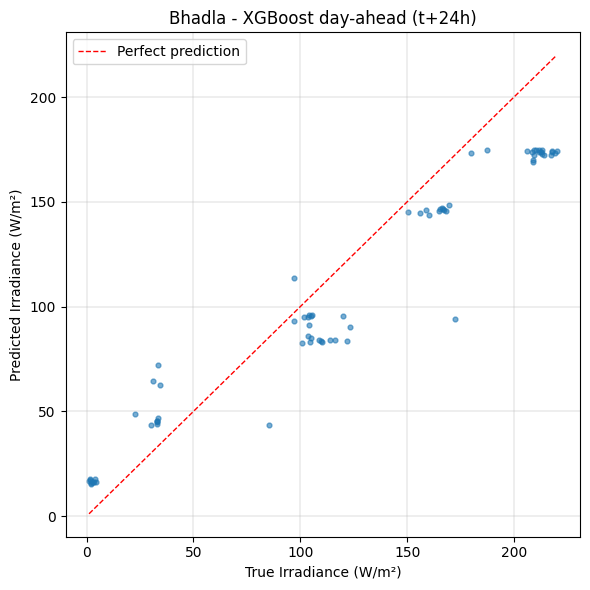

In [6]:
# Predict & evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f} W/m²")
print(f"✅ MAE : {mae:.2f} W/m²")
print(f"✅ R²  : {r2:.3f}")

# Per-hour-of-day error (for day-ahead pattern checks)
eval_df = pd.DataFrame({
    "target_time": df_site.loc[test_mask, "target_time"].values,
    "true": y_test.values,
    "pred": y_pred,
})
eval_df["hour_of_day"] = pd.to_datetime(eval_df["target_time"]).dt.hour
per_hour = eval_df.groupby("hour_of_day").apply(
    lambda g: pd.Series({
        "RMSE": np.sqrt(mean_squared_error(g["true"], g["pred"])),
        "MAE": mean_absolute_error(g["true"], g["pred"]),
        "Count": len(g)
    })
)
print("\nPer-hour-of-day errors (test):")
print(per_hour.round(2))

# Scatter: true vs pred
lo = float(min(y_test.min(), y_pred.min()))
hi = float(max(y_test.max(), y_pred.max()))
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, s=12)
plt.plot([lo, hi], [lo, hi], 'r--', linewidth=1, label="Perfect prediction")
plt.xlabel("True Irradiance (W/m²)")
plt.ylabel("Predicted Irradiance (W/m²)")
plt.title(f"{site_name} - XGBoost day-ahead (t+24h)")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

In [7]:
print(X_train.shape)

(296, 7)


<Figure size 800x600 with 0 Axes>

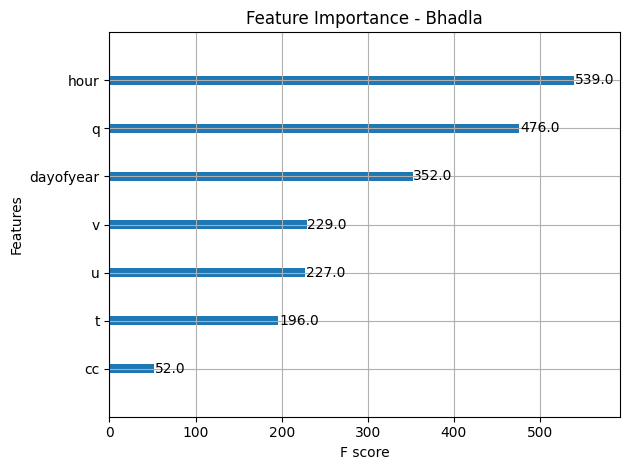

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plot_importance(model, importance_type="weight")  # "weight", "gain", or "cover"
plt.title(f"Feature Importance - {site_name}")
plt.tight_layout()
plt.show()